# <center>Scaling XGBoost Hyper-Parameter Optimization</center>

<img src="images/swarm.png" width="550"/>

# Motivation:

To reach highest performance in classification tasks (i.e., supervised learning ), it is best practice to build an ensemble of champion models. 

Each member of the ensemble is a winner of a search over many models of its kind with altered hyper-parameters.

In this notebook, we build a harness for running such a [hyper-parameter] search to demonstrate the accuracy benefits while exploring performance as we scale within and accross GPU nodes.

# Library Imports:

In [1]:
import ipyvolume as ipv
import matplotlib.pyplot as plt

import cudf
import cuml
import numpy as np
import pandas as pd
import xgboost

import dask
from dask import delayed
from dask_cuda import LocalCUDACluster
from dask.distributed import Client, LocalCluster, worker, as_completed
from dask_kubernetes import KubeCluster
import yaml

import data_utils
import swarm
import visualization as viz

# reload library modules/code without a kernel restart
import importlib; importlib.reload( swarm ); importlib.reload( data_utils ); importlib.reload( viz);
# ignore warnings
import warnings; warnings.filterwarnings('ignore')

-------

# PART 1 - Data Ingestion / Generation

-------

<center><a href='images/datasets.png'><img src="images/datasets.png" width="800"/></a></center>

# 1. Data

In this notebook you can try different hyper-parameter search methods using synthetic or real data.


In [2]:
datasetConfig = {  
    'datasetName'  : 'synthetic-swirl', #synthetic-helix', 'fashion-mnist', 'airline'
    'nSamples'     : 2000000,
    'localSaveDir' : './data/'
}

## 1.1 - Additional parameters are available for synthetic data

In [3]:
if 'synthetic' in datasetConfig['datasetName']:
    coilType = datasetConfig['datasetName'].split('-')[1]
    syntheticDetails = {
        'coilType'            : coilType,
        'coilDensity'         : 18 if coilType == 'swirl' else 9,
        'coil1StDev'          : .3,
        'coil2StDev'          : .3,
        'nGuidePointsPerCoil' : 1000,
        'shuffleFlag'         : True,
        'randomSeed'          : 0,
    }
    datasetConfig.update(syntheticDetails)
    
    # warmup - JIT compile data generation GPU kernels
    warmupConfig = datasetConfig.copy();
    warmupConfig['nSamples'] = 2
    data_utils.Dataset ( warmupConfig ) 

## 1.2 -  Load/Generate Data based on Configuration

In [4]:
%%time
dataset = data_utils.Dataset ( datasetConfig ) 

CPU times: user 1.36 s, sys: 33.6 ms, total: 1.39 s
Wall time: 1.39 s


In [5]:
dataset.data.shape

(2000000, 3)

# 2. Data Transformations

> **Splitting**: As is typical in machine learning workflows we need to split the dataset into a **train-set** and **test-set**. The test-set is unseen during training and model performance on the test-set is an indicator of how well our model(s) can generalize to future data [ also unseen during training ].

> **Scaling**: We can also apply standard scaling to each feature column of the dataset to ensure the data is numerically centered and ready for ingestion by an upstream model.
**Note**: This is an inplace operation which changes the value of the argument dataframe passed in without returning a value.


In [6]:
dataTransformsConfig =  { 
    'standardScaling'   : True,
    'percentTrainSplit' : .75,
    'shuffleAtSplit'    : True,
    'randomSeed'        : 0
}

> **Synthetic Splits**:  In the case of synthetic data, we use test with a distribution different than that of the train set in order to increase the difficulty of the problem and make it a challenge worthy of HPO. Specifically, we carve out the middle of the dataset along one of the synthetic dimensions [ x ], and assign these points to the test-set.

In [7]:
if 'synthetic' in datasetConfig['datasetName'] :    
    dataTransformsConfig['percentTrainSplit'] = .75 if datasetConfig['coilType'] == 'swirl' else .885
    dataTransformsConfig['samplesToSwap']     = int( dataset.data.shape[0] * .002 )
    assert ( dataset.data.shape[0] == datasetConfig['nSamples'])

## 2.1 - Apply Data Transforms

In [8]:
%%time
# fill missing values
missingIndicator = 0
dataset.data = dataset.data.fillna( missingIndicator )

CPU times: user 0 ns, sys: 6.58 ms, total: 6.58 ms
Wall time: 5.53 ms


In [9]:
%%time
if 'synthetic' not in datasetConfig['datasetName']:
    
    trainData, testData, \
    trainLabels, testLabels = cuml.train_test_split( dataset.data,  dataset.labels, 
                                                     train_size = dataTransformsConfig['percentTrainSplit'] )    
else:
    trainData, testData, \
    trainLabels, testLabels = data_utils.split_synthetic ( dataset.data, dataset.labels, 
                                                           percentTrain = dataTransformsConfig['percentTrainSplit'], 
                                                           samplesToSwap = dataTransformsConfig['samplesToSwap'] )

dataset.assign_dataset_splits ( trainData, testData, trainLabels, testLabels )

splitting synthetic dataset into train-set 75.0% and test-set 25.0%
> assigning middle span of data to test-set
> swapping 4000 samples between train-set and test-set
CPU times: user 841 ms, sys: 26.7 ms, total: 867 ms
Wall time: 873 ms


In [10]:
%%time
# apply standard scaling inplace to train-set and test-set
trainMeans, trainSTDevs, _ = data_utils.scale_dataframe_inplace ( dataset.trainData, label='train-set', datasetObject = dataset )
_,_,_ = data_utils.scale_dataframe_inplace ( dataset.testData, trainMeans, trainSTDevs, label='test-set', datasetObject = dataset )

applying [inplace] standard scaling to train-set data
applying [inplace] standard scaling to test-set data
CPU times: user 399 ms, sys: 0 ns, total: 399 ms
Wall time: 396 ms


# 3. Visualize in 3D [ Embed ]

In [11]:
embeddingOptions = {
    'PCA'  : { 'method': 'PCA', 'sampleLimit': 200000 },
    'UMAP' : { 'method': 'UMAP', 'sampleLimit': 15000 },    
}

In [12]:
vizConfig = {
    'maxSamplesToPlot' : 200000,
    'embedding'        : embeddingOptions['UMAP']
}    

In [13]:
viz.plot_data_train_vs_test( dataset, vizConfig )

shuffling and decimating - train-set ... test-set ...
computing feature distributions in 0.73 seconds
elapsed time : 1.180328369140625


-------

# PART 2 - Model and Parameter Intro

-------

# 4. Manual Hyper-Parameter Choice [ a.k.a., Can you beat HPO? ]

In [14]:
# flexible parameters -- read more @ https://xgboost.readthedocs.io/en/latest/parameter.html

manualXGBoostParams = { 
    'max_depth': 6,                     # default = 6             :: maximum depth of a tree
    'num_boost_round': 100,              # default = XXX           :: number of trees        
    'learning_rate': 0.3,               # default = 0.3           :: step size shrinkage between rounds, prevents overfitting
    'gamma': 0.,                        # default = 0             :: minimum loss reduction required to make a leaf node split, prevents overfitting
    'lambda': 1.,                       # default = 1             :: L2 regularizaiton term on weights, prevents overfitting
    'alpha': 0.,                        # default = 0             :: L1 regularization term on weights, prevents overfitting
    'tree_method': 'gpu_hist',          # default = 'gpu_hist'    :: tree construction algorithm
    'random_state' : 0 
}
# note: we'll inherit objective function [ & num_class ] from the dataset

In [15]:
trainedGPUModel, trainTimeGPU, inferenceTimeGPU = swarm.evaluate_manual_params( dataset, manualXGBoostParams )

train accuracy : 0.9318 in 0.6994 seconds
test  accuracy : 0.7494 in 0.0098 seconds


In [16]:
runCPUComparison = True
if runCPUComparison:
    trainedCPUModel, trainTimeCPU, inferenceTimeCPU = swarm.evaluate_manual_params_CPU ( dataset, manualXGBoostParams, nCPUWorkers = 4 )
    print( f' train speedup     : {trainTimeCPU / trainTimeGPU:0.2f} ' )
    print( f' inference speedup : {inferenceTimeCPU / inferenceTimeGPU:0.2f} ' )

train accuracy : 0.9329 in 13.9291 seconds
test  accuracy : 0.8426 in 0.6179 seconds
 train speedup     : 19.91 
 inference speedup : 63.27 


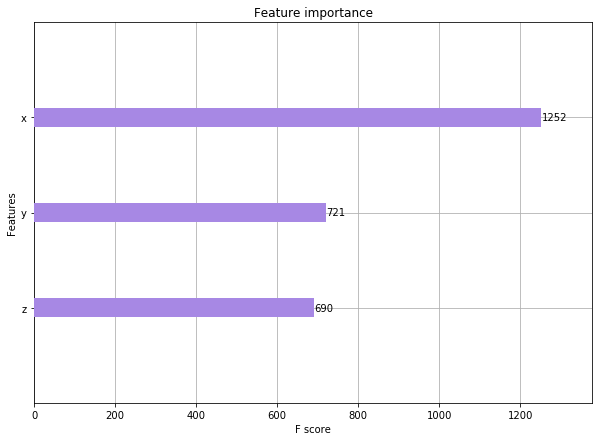

In [17]:
viz.plot_feature_importance( trainedGPUModel )

In [18]:
%%time
modelDetailPlots = True

if modelDetailPlots: 
    if 'synthetic' in datasetConfig['datasetName']: 
        nTrees = 5
    else: 
        nTrees = 1
        
    viz.plot_first_N_trees( trainedGPUModel, nTrees = nTrees )

(810, 27)
CPU times: user 586 ms, sys: 164 ms, total: 750 ms
Wall time: 1.6 s


# 5. Model Settings for HPO and Parameter Search Ranges

> **Note**: number of trees will be allowed to freely range between 0-2000 with an early stopping settting of 250

In [19]:
modelConfig = {
    'name'                  : 'XGBoost',    
                              # parameter        low    high    dtype 
    'tunableParam1'         : ['max_depth',      2,     15,    'int'   ],
    'tunableParam2'         : ['learning_rate',  .001,  2,     'float' ],
    'tunableParam3'         : ['gamma',          0.,    3.,    'float' ],
    
    'nTrees-ceiling'        : 2000,
    'early-stopping-rounds' : 250,
    'randomSeed'            : 0,    
}

-------

# PART 3 - Hyper Parameter Optimization

-------

## <center> Scaling Compute with Kubernetes and Dask</center>

<center><img src='images/scaling.png' width='1000px'></center>

## <center> Sync vs Async [ Dask Task Stream ] </center>

<center><img src='images/sync_vs_async.png' width='800px'></center>

# 6. Compute Cluster

In [20]:
computeConfig = {
    'clusterType' : 'LocalCUDACluster', # LocalCUDACluster # KubeCluster
    'nWorkers'     : 4
}

In [23]:
workerSpec = '''
# worker-spec.yml
kind: Pod
metadata:
  labels:
    foo: bar
spec:
  restartPolicy: Never
  containers:
  - image: ericharper/rapids-dask-hpo:latest
    imagePullPolicy: IfNotPresent
    args: [dask-worker,  --nthreads, '1', --no-bokeh, --memory-limit, 6GB, --no-bokeh, --death-timeout, '60']
    name: dask
    resources:
      limits:
        cpu: "2"
        memory: 6G
        nvidia.com/gpu: 1
      requests:
        cpu: "2"
        memory: 6G
        nvidia.com/gpu: 1
'''

In [24]:
if computeConfig['clusterType'] == 'LocalCUDACluster': # multi-GPU [ within a node ]
    cluster = LocalCUDACluster( ip = '', n_workers = computeConfig['nWorkers'])
    
elif computeConfig['clusterType'] == 'LocalCluster': # CPU
    cluster = LocalCluster( ip = '', n_workers = computeConfig['nWorkers'])
    
elif computeConfig['clusterType'] == 'KubeCluster': # multi-node multi-GPU
    cluster = KubeCluster.from_yaml(workerSpec)

In [25]:
cluster

In [26]:
client = Client( cluster, asynchronous = True)

# 7. HPO Strategy

>  Particle Swarm vs Random Search 

> Synchronous vs Asynchronous

[1] https://en.wikipedia.org/wiki/Particle_swarm_optimization#Algorithm

In [27]:
HPOConfig = { 
    'strategy'        : 'sync', # sync # async # async-random
    'nParticles'      : 16,
    'nEpochs'         : 10,
    'asyncWarmupFlag' : False,
    'randomSeed'      : 0
}

# 8. Run Experiment

In [28]:
if HPOConfig['strategy'] == 'sync':
    expSwarm = swarm.SyncSwarm( client, dataset, HPOConfig, modelConfig, computeConfig )
    expSwarm.run_search()
    
elif HPOConfig['strategy'] == 'async':
    expSwarm = swarm.AsyncSwarm( client, dataset, HPOConfig, modelConfig, computeConfig )    
    expSwarm.run_search( syncWarmupFlag = HPOConfig['asyncWarmupFlag'] )
    
elif HPOConfig['strategy'] == 'async-random':
    expSwarm = swarm.RandomSearchAsync( client, dataset, HPOConfig, modelConfig, computeConfig )    
    expSwarm.run_search()

! initializing SyncSwarm, with 16 particles, and 10 epochs

   pID |      max_depth,  learning_rate,          gamma
     0 |              2,           0.00,           0.00 
     1 |              7,           1.87,           3.00 
     2 |             10,           1.86,           1.45 
     3 |             12,           1.68,           1.71 
     4 |             12,           0.35,           1.83 
     5 |              5,           1.66,           2.94 
     6 |             12,           0.42,           1.11 
     7 |              6,           0.88,           2.93 
     8 |              5,           0.48,           2.45 
     9 |             14,           0.99,           0.43 
    10 |             11,           0.99,           2.50 
    11 |             11,           1.33,           2.78 
    12 |             13,           1.75,           2.17 
    13 |              4,           1.72,           0.54 
    14 |             13,           1.32,           0.45 
    15 |             15,     

In [29]:
# TODO: Describe how to enable GPU Utilization and Memory Profiling as well as Dask Task Stream [ RAPIDS Jupyter Lab Plugins]

## 8.1 - Visualize Swarm

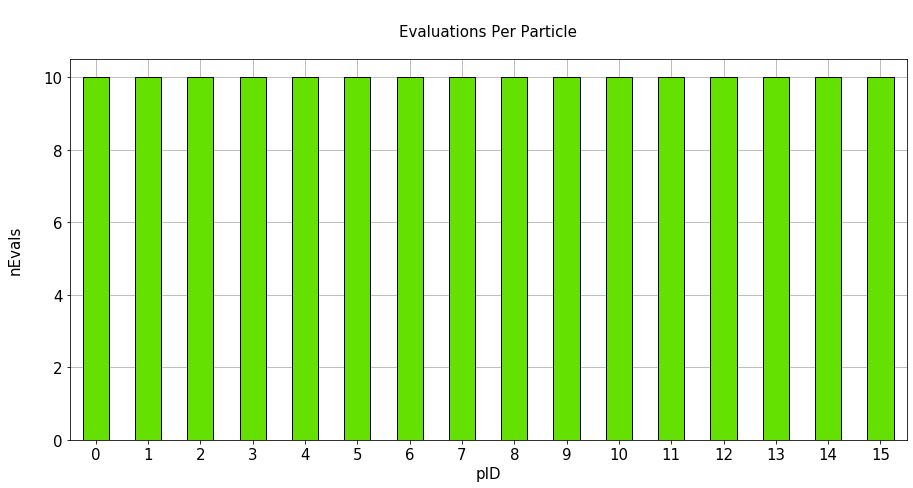

In [30]:
viz.plot_particle_evals( expSwarm )

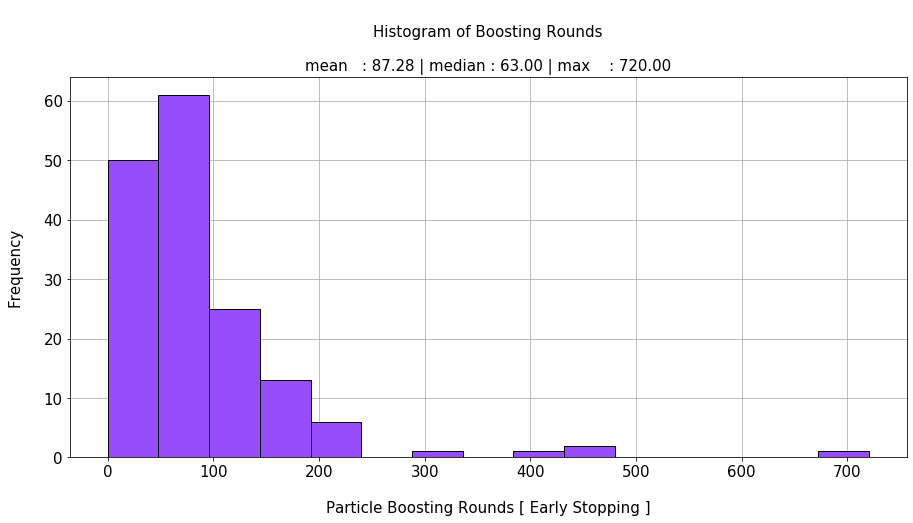

In [31]:
viz.plot_boosting_rounds_histogram( expSwarm )

In [32]:
viz.viz_top_particles( expSwarm )
# viz.viz_particle_trails(expSwarm, topN = 1) # for non-tabbed results

In [33]:
viz.viz_swarm( expSwarm, expSwarm.paramRanges)

# 9. Accelerated Inference

In [35]:
inferenceConfig = {
    'accelerateInference' : True
}
# TODO add FIL

# 10. Experiment Summary

In [36]:
exp = { 'dataset' : datasetConfig, 
        'transforms' : dataTransformsConfig,       
        'visualization' : vizConfig,
        'model' : modelConfig,
        'HPO_strategy' : HPOConfig,
        'compute_strategy' : computeConfig,
        'inference_strategy' : inferenceConfig }

# 10.1 - Save experiment

In [37]:
with open('experiment.yaml', 'w') as outfile:
    yaml.dump(exp, outfile)

In [38]:
print( yaml.dump(exp) )

HPO_strategy:
  asyncWarmupFlag: false
  nEpochs: 10
  nParticles: 16
  randomSeed: 0
  strategy: sync
compute_strategy:
  clusterType: LocalCUDACluster
  nWorkers: 4
dataset:
  coil1StDev: 0.3
  coil2StDev: 0.3
  coilDensity: 18
  coilType: swirl
  datasetName: synthetic-swirl
  localSaveDir: ./data/
  nGuidePointsPerCoil: 1000
  nSamples: 2000000
  randomSeed: 0
  shuffleFlag: true
inference_strategy:
  accelerateInference: true
model:
  early-stopping-rounds: 250
  nTrees-ceiling: 2000
  name: XGBoost
  randomSeed: 0
  tunableParam1:
  - max_depth
  - 2
  - 15
  - int
  tunableParam2:
  - learning_rate
  - 0.001
  - 2
  - float
  tunableParam3:
  - gamma
  - 0.0
  - 3.0
  - float
transforms:
  percentTrainSplit: 0.75
  randomSeed: 0
  samplesToSwap: 4000
  shuffleAtSplit: true
  standardScaling: true
visualization:
  embedding:
    method: UMAP
    sampleLimit: 15000
  maxSamplesToPlot: 200000



In [39]:
with open('experiment.yaml', 'r') as infile:
    cachedExp = yaml.load(infile)
cachedExp

{'HPO_strategy': {'asyncWarmupFlag': False,
  'nEpochs': 10,
  'nParticles': 16,
  'randomSeed': 0,
  'strategy': 'sync'},
 'compute_strategy': {'clusterType': 'LocalCUDACluster', 'nWorkers': 4},
 'dataset': {'coil1StDev': 0.3,
  'coil2StDev': 0.3,
  'coilDensity': 18,
  'coilType': 'swirl',
  'datasetName': 'synthetic-swirl',
  'localSaveDir': './data/',
  'nGuidePointsPerCoil': 1000,
  'nSamples': 2000000,
  'randomSeed': 0,
  'shuffleFlag': True},
 'inference_strategy': {'accelerateInference': True},
 'model': {'early-stopping-rounds': 250,
  'nTrees-ceiling': 2000,
  'name': 'XGBoost',
  'randomSeed': 0,
  'tunableParam1': ['max_depth', 2, 15, 'int'],
  'tunableParam2': ['learning_rate', 0.001, 2, 'float'],
  'tunableParam3': ['gamma', 0.0, 3.0, 'float']},
 'transforms': {'percentTrainSplit': 0.75,
  'randomSeed': 0,
  'samplesToSwap': 4000,
  'shuffleAtSplit': True,
  'standardScaling': True},
 'visualization': {'embedding': {'method': 'UMAP', 'sampleLimit': 15000},
  'maxSamplesT

# 11. Scale Up Results [ DGX-2 ]

<img src='images/synthetic_async.png'></img>

# Summary

# Future Work / Extensions

larger than single GPU memory datasets - dask_cudf + [ dask_xgboost or xgboost.dask ]

# References